C:\Users\gabriel\AppData\Local\Temp\ipykernel_24196\955869564.py:29: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  gaussian_points = np.random.multivariate_normal(mean, cov, points_per_gaussian)


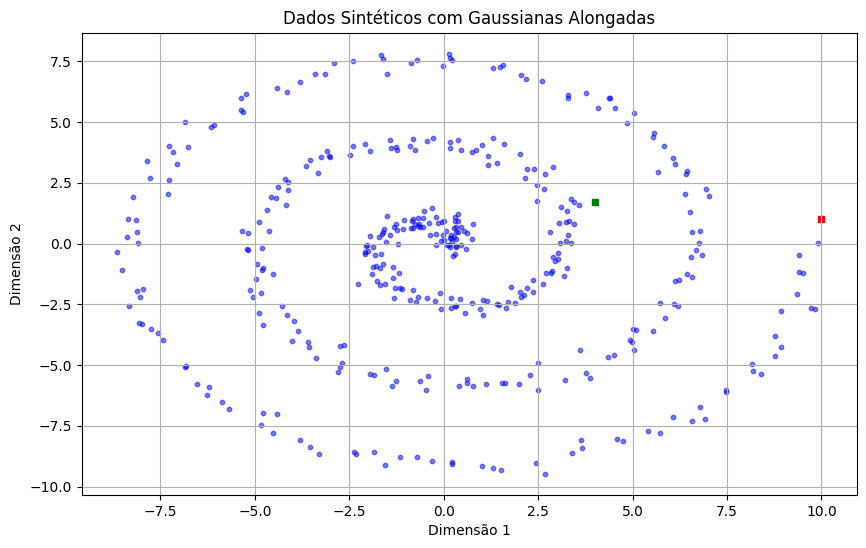

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.interpolate import interp1d

# Configurações das gaussianas
np.random.seed(42)  # Para reprodutibilidade
num_gaussians = 5
points_per_gaussian = 500

# Parâmetros de cada gaussiana (média e covariância)
means = [
    [0, 0],
    [5, 3],
    [10, 2],
    [15, 1],
]

covariances = [
    [[2, 3], [0, 0.5]],
    [[5,0], [0.2, 0.5]],
    [[3, -2], [0, 0]],
    [[1.2, 0.6], [0.6, 1]],
]

# Gerar os dados
data = []
for mean, cov in zip(means, covariances):
    gaussian_points = np.random.multivariate_normal(mean, cov, points_per_gaussian)
    data.append(gaussian_points)

data = np.vstack(data)

# Adicionar ruído
noise = np.random.normal(0, 0.2, data.shape)
data_with_noise = data + noise


def gmm_principal_curve(data, n_components=5):
    """
    Approximate a principal curve using a Gaussian Mixture Model.
    
    Parameters:
    - data: np.ndarray, shape (n_samples, n_features)
      Input data.
    - n_components: int
      Number of Gaussian components in the GMM.
    - n_points: int
      Number of points to sample on the principal curve.

    Returns:
    - curve: np.ndarray, shape (n_points, n_features)
      The computed principal curve.
    """
    # Fit GMM to the data
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(data)

    # Extract means of the GMM components
    means = gmm.means_
    covariances = gmm.covariances_
        
    # Sort means along a principal axis (e.g., first component)
    sort_indices = np.argsort(means[:, 0])
    means_sorted = means[sort_indices]
    covariances_sorted = covariances[sort_indices]
    
    ellipses = []
    curve = []
    for i, mean in enumerate(means_sorted):
        # Compute PCA on the covariance matrix
        eigvals, eigvecs = np.linalg.eigh(covariances_sorted[i])
        
        # Take the second principal component
        std_dev0 = np.sqrt(eigvals[0]) 
        direction0 = eigvecs[:, 0]    
        std_dev1 = np.sqrt(eigvals[1]) 
        direction1 = eigvecs[:, 1]    
        
        # Scale the direction for visualization (2 * sqrt(2) * std_dev)
        scaled_direction0 = 2 * np.sqrt(2) * std_dev0 * direction0
        scaled_direction1 = std_dev1 * direction1
        
        # Save ellipse data
        ellipses.append({
            'center': mean,
            'direction': direction0,
            'scaled_direction': scaled_direction0
        })
        curve.append({
            'center': mean,
            'direction': direction1,
            'scaled_direction': scaled_direction1
        })
    
    return curve, ellipses
K = 15
import pandas as pd 
file_path = '../data/spiral_data.csv'  # Update the path if necessary
spiral_data = pd.read_csv(file_path)

# Extract x and y coordinates
x_data = spiral_data['x']
y_data = spiral_data['y']
data_with_noise = np.column_stack((x_data, y_data))
curve, ellipses = gmm_principal_curve(data_with_noise, K)

validation_data_wrong = np.array([[10, 1]]) 
validation_data_right = np.array([[4, 1.7]]) 
    
# Plotar os dados
plt.figure(figsize=(10, 6))
plt.scatter(data_with_noise[:, 0], data_with_noise[:, 1], s=10, alpha=0.5, c='blue')
plt.scatter(validation_data_wrong[:, 0], validation_data_wrong[:, 1], s=15, c='red', marker='s')
plt.scatter(validation_data_right[:, 0], validation_data_right[:, 1], s=15, c='green', marker='s')
points = np.zeros((len(ellipses), data_with_noise.shape[1]))
tangents =  np.zeros((len(ellipses), data_with_noise.shape[1]))


# plt.plot(cubic[:, 0], cubic[:, 1], color='red', label='Principal Curve', lw=1)
plt.title("Dados Sintéticos com Gaussianas Alongadas")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.grid(True)


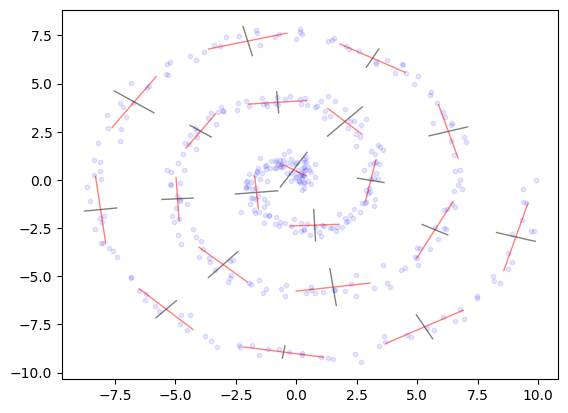

In [ ]:
from scipy import interpolate

def sampleCubicSplinesWithDerivative(points, tangents, resolution):
    '''
    Compute and sample the cubic splines for a set of input points with
    optional information about the tangent (direction AND magnitude). The 
    splines are parametrized along the traverse line (piecewise linear), with
    the resolution being the step size of the parametrization parameter.
    The resulting samples have NOT an equidistant spacing.

    Arguments:      points: a list of n-dimensional points
                    tangents: a list of tangents
                    resolution: parametrization step size
    Returns:        samples

    Notes: Lists points and tangents must have equal length. In case a tangent
           is not specified for a point, just pass None. For example:
                    points = [[0,0], [1,1], [2,0]]
                    tangents = [[1,1], None, [1,-1]]

    '''
    resolution = float(resolution)
    points = np.asarray(points)
    nPoints, dim = points.shape

    # Parametrization parameter s.
    dp = np.diff(points, axis=0)                 # difference between points
    dp = np.linalg.norm(dp, axis=1)              # distance between points
    d = np.cumsum(dp)                            # cumsum along the segments
    d = np.hstack([[0],d])                       # add distance from first point
    l = d[-1]                                    # length of point sequence
    nSamples = int(l/resolution)                 # number of samples
    s,r = np.linspace(0,l,nSamples,retstep=True) # sample parameter and step

    # Bring points and (optional) tangent information into correct format.
    assert(len(points) == len(tangents))
    data = np.empty([nPoints, dim], dtype=object)
    for i,p in enumerate(points):
        t = tangents[i]
        # Either tangent is None or has the same
        # number of dimensions as the point p.
        assert(t is None or len(t)==dim)
        fuse = list(zip(p,t) if t is not None else zip(p,))
        data[i,:] = fuse

    # Compute splines per dimension separately.
    samples = np.zeros([nSamples, dim])
    for i in range(dim):
        poly = interpolate.BPoly.from_derivatives(d, data[:,i])
        samples[:,i] = poly(s)
    return samples

for i, ellipse in enumerate(ellipses):
    center = ellipse['center']
    scaled_direction = ellipse['scaled_direction']
    
    # Create ellipse vertices
    ellipse_points = np.array([
        center + scaled_direction,
        center - scaled_direction
    ])
    
    center_seg = curve[i]['center']
    scaled_direction_seg = curve[i]['scaled_direction']
    
    # Create ellipse vertices
    seg_points = np.array([
        center_seg + scaled_direction_seg,
        center_seg - scaled_direction_seg
    ])
    points[i] = center_seg
    tangents[i] = seg_points[1] - seg_points[0]
    # Plot the ellipse
    plt.plot(ellipse_points[:, 0], ellipse_points[:, 1], color='black', lw=1, alpha=0.5)
    plt.plot(seg_points[:, 0], seg_points[:, 1], color='red', lw=1, alpha=0.5)
    
resolution = 0.2
points = np.asarray(points)

# Interpolate with different tangent lengths, but equal direction.
scale = 1/K*3
tangents = np.dot(np.asarray(tangents), scale*np.eye(2))

samples = sampleCubicSplinesWithDerivative(points, tangents, resolution)
M = 200
t = np.linspace(0, len(samples[:,0]), M)
x = np.interp(t, np.arange(len(samples[:,0])), samples[:,0])
y = np.interp(t, np.arange(len(samples[:,1])), samples[:,1])

plt.scatter(data_with_noise[:, 0], data_with_noise[:, 1], s=10, alpha=0.1, c='blue')
# plt.plot(x, y, label='samples1', color='red')



plt.show()


In [224]:
from scipy.spatial.distance import cdist


def distance_matrix_with_exclusions_scipy_nested(pairs):
    """
    Calculate a distance matrix from nested point pairs using scipy.spatial.distance.cdist,
    excluding distances between paired points.
    
    Args:
        pairs (numpy.ndarray): A 3D numpy array of shape (n, 2, 2),
                               where pairs[i][0] and pairs[i][1] form a pair.
    
    Returns:
        numpy.ndarray: A 2D distance matrix with np.inf where distances between paired points are excluded.
    """
    
    # Compute the full distance matrix
    dist_matrix = cdist(points, points)
    
    np.fill_diagonal(dist_matrix, np.inf)
    
    # Exclude distances between paired points
    n_pairs = len(pairs) // 2
    for i in range(n_pairs):
        idx1 = i * 2     # Index of the first point in the pair
        idx2 = idx1 + 1  # Index of the second point in the pair
        dist_matrix[idx1, idx2] = np.inf
        dist_matrix[idx2, idx1] = np.inf
    
    return dist_matrix

def sort_by_distance_indices(dist_matrix):
    """
    Sort each row of the distance matrix in ascending order, storing the indices of the points.
    
    Args:
        dist_matrix (numpy.ndarray): A 2D numpy array representing the distance matrix.
    
    Returns:
        numpy.ndarray: A 2D numpy array where each row contains the indices of points sorted by distance.
    """
    # Use argsort along rows to get indices of sorted distances
    sorted_indices = np.argsort(dist_matrix, axis=1)
    return sorted_indices


dist_matrix = distance_matrix_with_exclusions_scipy_nested(tangents)
sorted_indices = sort_by_distance_indices(dist_matrix)